In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
import scipy.stats as stats
from ipywidgets import FloatProgress
from IPython.display import display
import os.path
from os import path

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

In [2]:
def drawHeatMap(dataArray, imageSize, x, y, nData=[], colorBarLabel="", textOn=True, forceInt=True):
    dx = x[(1,0)] - x[(0,0)];
    dy = y[(0,1)] - y[(0,0)];
    extent = [x[(0,0)], x[(-1,0)]+dx,y[(0,0)],y[(0,-1)]+dy];
    plt.figure(figsize=imageSize);
    # fig, ax = plt.subplots(figsize=imageSize);
    ax = plt.gca()

    da = np.transpose(dataArray);
#    im = ax.imshow(da, extent = extent, origin='lower');
    im = ax.imshow(da, extent = extent, origin='lower', cmap="Greys");
    ax.set_aspect(10);
    
    if len(nData) == 0:
        nData = np.ones(dataArray.shape)

    # ax.imshow(da, origin='lower');
    arrayShape = da.shape;
    minda = np.min(da)
    maxda = np.max(da)
    daRange = maxda - minda;
    for i in range(arrayShape[0]):
        for j in range(arrayShape[1]):
            if da[i, j] > minda + daRange*0.5:
                # cstr = "k"
                cstr = "w"
            else:
                # cstr = "w"
                cstr = "k"
            if np.abs(da[i,j]) < 100:
                fsz = 9
            else:
                fsz = 6
            
            if textOn:
                if nData[(j,i)] > 0:
                    if forceInt:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j].astype("int"),
                               ha="center", va="center", color=cstr, fontsize=fsz)
                    else:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j],
                               ha="center", va="center", color=cstr, fontsize=fsz)                        
                else:
                    ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, "-",
                           ha="center", va="center", color=cstr, fontsize=fsz)

            
    
    ax.tick_params(axis = "both", labelsize = 12)
    im_ratio = float(da.shape[0])/da.shape[1] 
    cbh = plt.colorbar(im,fraction=0.0477*im_ratio, pad=0.02)
    cbh.ax.set_ylabel(colorBarLabel, fontSize = 16);

    # ax.invert_yaxis();
    


In this notebook we measure DR25 vetting completeness, defined as the fraction of detections (TCEs) that are correctly vetted as planet candidates.  We use the set of injected on-target planets that were detected at the correct ephemeris as the base set of TCEs.  All of these TCEs are "true planets" by definition.  Then vetting completeness is the fraction of these TCEs that are vetter as PC by the robovetter.  We study how vetting completeness depends on period and MES.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting PCs. We identify $r$ with vetting completeness.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

In this spirit, we define the vetting effectiveness $r$ as the probability of drawing PCs from inverted/scrambled TCEs, found via the Bayesian inference $p(r|n, c) \propto p(c|r, n) p(r)$, where $c$ is the number of TCEs vetted as PCs, $n$ is the total number of TCEs,
$$p(c|r, n) = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}$$ and
$p(r)$ is a prior distribution of the probability $r$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $r(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.


First we define our stellar and planet populations.

In [3]:
figDir = "summaryFigures"

dataType = "dr25"
bootstrapType = ""
scoreCut = 0.6;
# outputDir = bootstrapType + "Output/"
outputDir = dataType + "Sc" + str(scoreCut) + "Output/"
print(outputDir)

htmlLabel = dataType + "Sc" + str(scoreCut) + bootstrapType
print(htmlLabel)

stellarType = "hab"


scenario = "large"
if scenario == "small":
    # small planet long period scenario
    periodMin = 200;
    periodMax = 400;
    rpMin = 0.75;
    rpMax = 2.5;
    mesMin = 0;
    mesMax = 30;
elif scenario == "large":
    # all planet scenario
    periodMin = 0;
    periodMax = 500;
    rpMin = 0.5;
    rpMax = 15;
    mesMin = 0;
    mesMax = 30;
else:
    raise ValueError('Bad scenario name');


dr25Sc0.6Output/
dr25Sc0.6


Then we define our binomial probability distribution function.

In [4]:
def binPdf(n, r, c):
    return sp.comb(n,c)*(r**c)*((1-r)**(n-c));

Then we define a bunch of models of the rate as functions of period ($x$) and MES ($y$) which are identified by the variable 'model'.

Read in our data.

In [5]:
dataLoc = "../data/"
if dataType == "dr25":
    injTceList = dataLoc + "kplr_dr25_inj1_tces.txt"
else:
    injTceList = dataLoc + "kplr_dr25_inj1_" + dataType + "_tces.txt"
tcelist = dataLoc + "DR25-Injected-Recovered-OnTarget-Planet-TCEs-1-1-Prat.txt"
# starlist = dataLoc + "dr25_stellar_updated_feh_" + stellarType + ".txt"
if bootstrapType == "":
    starlist = "../stellarCatalogs/dr25_stellar_berger2020_clean_" + stellarType + ".txt"
else:
    starlist = "bootstrapOut/" + bootstrapType + "StellarCatalog.csv"
    

In [6]:
# Load the stellar population we want to use
kic = pd.read_csv(starlist)
# Load D2 table
injTces = ascii.read(injTceList)
tces = np.genfromtxt(tcelist, dtype='str')

tceKepids = np.zeros(len(tces));
for i in range(len(tces)):
    s = tces[i].split('-');
    tceKepids[i] = int(s[0]);
print(tceKepids)

print("num injected/recovered TCEs: " + str(np.size(tceKepids)))
print("num injected TCEs: " + str(np.size(injTces)))



[  757280.   891916.   892195. ... 12984183. 12984200. 12984214.]
num injected/recovered TCEs: 46463
num injected TCEs: 45377


In [7]:
injTces = injTces[np.in1d(injTces['TCE_ID'],tces)]
print("num injected TCEs after trimming to injected/recovered: " + str(np.size(injTces)))


num injected TCEs after trimming to injected/recovered: 44794


In [8]:
# Select only those TCEs that are in this stellar population
injTces = injTces[np.in1d(injTces['KIC'],kic.kepid)]
print("after: " + str(np.size(injTces)))


after: 17559


In [9]:
injTces = injTces.to_pandas();



In [10]:
injTces = pd.merge(injTces, kic, left_on="KIC", right_on="kepid", how="inner")


In [11]:
# Do some basic stats
print(injTceList)
print("# of injected TCEs: " + str(len(injTces)))
print("# of injected PCs: " + str(len(injTces[injTces['Disp']=='PC'])))
print("# of injected FPs: " + str(len(injTces[injTces['Disp']=='FP'])))
print(' ')

print("for " + str(rpMax) + " < Rp < " + str(rpMax) + ", " + str(periodMin) + " < period < " + str(periodMax) + ":");
print("# of injected injected TCEs: " + str(len(injTces[np.all([                   \
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))
print("# of injected PCs: " + str(len(injTces[np.all([injTces['Disp']=='PC',\
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))
print("# of injected FPs: " + str(len(injTces[np.all([injTces['Disp']=='FP',\
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)])))


../data/kplr_dr25_inj1_tces.txt
# of injected TCEs: 17559
# of injected PCs: 15410
# of injected FPs: 2149
 
for 15 < Rp < 15, 0 < period < 500:
# of injected injected TCEs: 17554
# of injected PCs: 15405
# of injected FPs: 2149


Separate out the PCs and FPs

In [12]:
pcIndex = injTces['Disp']=='PC'
fpIndex = injTces['Disp']=='FP'
pcs = injTces[pcIndex]
fps = injTces[fpIndex]

Select the TCEs that are in our desired population and plot them.

In [13]:
spIndex = np.all([
    injTces['Rp']>rpMin,injTces['Rp']<rpMax,injTces['period']>periodMin,injTces['period']<periodMax], axis=0)
spInjTces = injTces[spIndex]
spInjPcs = spInjTces[(spInjTces['Disp']=='PC') & (spInjTces['Score']>=scoreCut)]
spInjFps = spInjTces[(spInjTces['Disp']=='FP') | (spInjTces['Score']<scoreCut)]


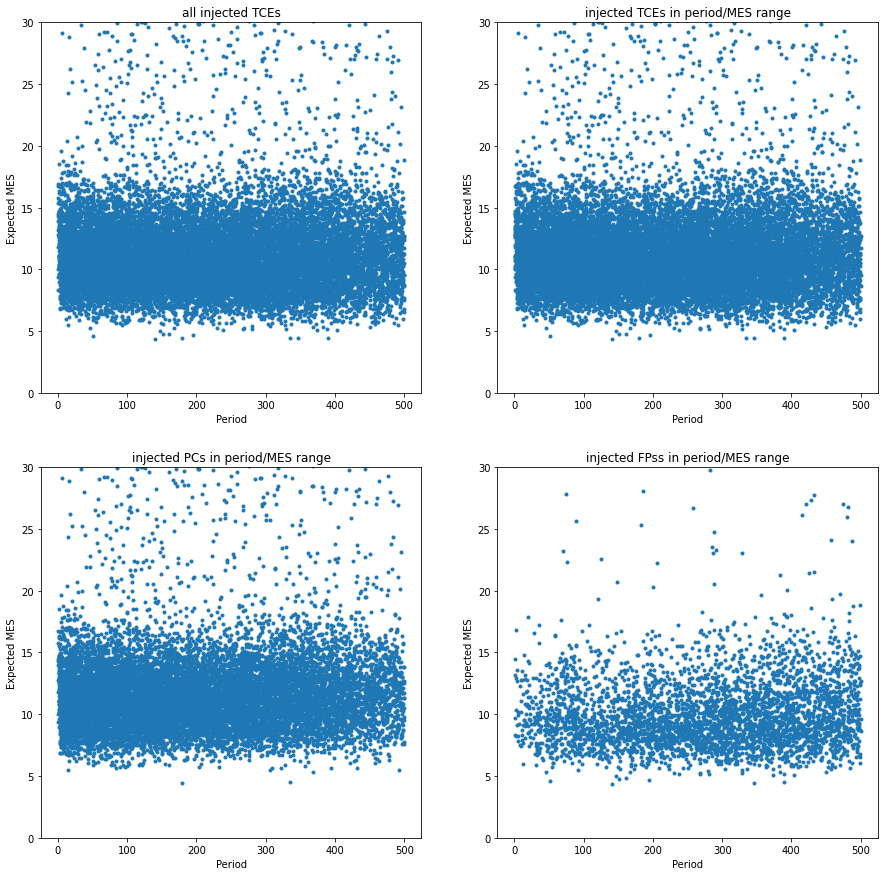

In [14]:
plt.figure(figsize=(15,15));
plt.subplot(2,2,1);
plt.scatter(injTces['period'], injTces['Expected_MES'], marker=".");
plt.ylim(0,mesMax);
plt.title("all injected TCEs");
plt.ylabel('Expected MES');
plt.xlabel('Period');
plt.subplot(2,2,2);
plt.scatter(spInjTces['period'], spInjTces['Expected_MES'], marker=".");
plt.ylim(0,mesMax);
plt.title("injected TCEs in period/MES range");
plt.xlabel('Period');
plt.ylabel('Expected MES');
plt.subplot(2,2,3);
plt.scatter(spInjPcs['period'], spInjPcs['Expected_MES'], marker=".");
plt.ylim(0,mesMax);
plt.title("injected PCs in period/MES range");
plt.ylabel('Expected MES');
plt.xlabel('Period');
plt.subplot(2,2,4);
plt.scatter(spInjFps['period'], spInjFps['Expected_MES'], marker=".");
plt.ylim(0,mesMax);
plt.title("injected FPss in period/MES range");
plt.ylabel('Expected MES');
plt.xlabel('Period');


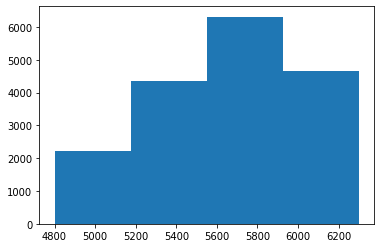

In [15]:
plt.hist(spInjTces['teff'], 4);

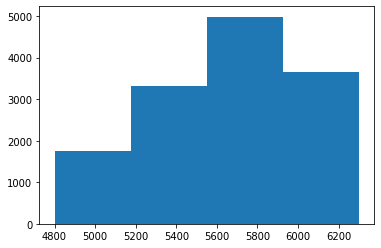

In [16]:
plt.hist(spInjPcs['teff'], 4);

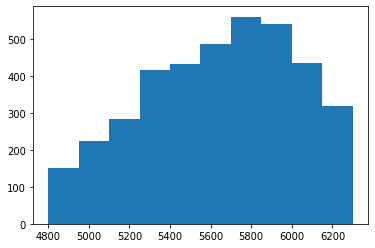

In [17]:
plt.hist(spInjFps['teff']);

Bin the populations onto a grid.  The binned TCEs and PCs are the input to our MCMC analysis.

In [18]:
dPeriod = 20; 
dMes = 2;

p0 = periodMin;
pEnd = periodMax;
m0 = mesMin;
mEnd = mesMax;

TeffMin = np.min(injTces['teff'])
TeffMax = np.max(injTces['teff'])
dTeff = (TeffMax - TeffMin)/3

# make the period-mes grid
NPeriod = int((pEnd - p0)/dPeriod);
NMes = int((mEnd - m0)/dMes);
NTeff = int((TeffMax - TeffMin)/dTeff);
tceGrid = np.zeros((NPeriod,NMes,NTeff));
cellPeriod = np.zeros((NPeriod,NMes,NTeff));
cellMes = np.zeros((NPeriod,NMes,NTeff));
cellTeff = np.zeros((NPeriod,NMes,NTeff));
pcGrid = np.zeros((NPeriod,NMes,NTeff));
fpGrid = np.zeros((NPeriod,NMes,NTeff));

# count how many points are in each cell
for p in range(NPeriod):
    for m in range(NMes):
        for t in range(NTeff):
            cellPeriod[(p,m,t)] = p0 + p*dPeriod;
            cellMes[(p,m,t)] = m0 + m*dMes;
            cellTeff[(p,m,t)] = TeffMin + t*dTeff;
            pointsInCell = np.where(
                (spInjTces['period'] > cellPeriod[(p,m,t)]) 
                & (spInjTces['period'] <= cellPeriod[(p,m,t)]+dPeriod) 
                & (spInjTces['Expected_MES'] > cellMes[(p,m,t)]) 
                & (spInjTces['Expected_MES'] <= cellMes[(p,m,t)]+dMes)
                & (spInjTces['teff'] > cellTeff[(p,m,t)]) 
                & (spInjTces['teff'] <= cellTeff[(p,m,t)]+dTeff));
            tceGrid[(p,m,t)] = len(pointsInCell[0]);

            pointsInCell = np.where(
                (spInjPcs['period'] > cellPeriod[(p,m,t)]) 
                & (spInjPcs['period'] <= cellPeriod[(p,m,t)]+dPeriod) 
                & (spInjPcs['Expected_MES'] > cellMes[(p,m,t)]) 
                & (spInjPcs['Expected_MES'] <= cellMes[(p,m,t)]+dMes)
                & (spInjPcs['teff'] > cellTeff[(p,m,t)]) 
                & (spInjPcs['teff'] <= cellTeff[(p,m,t)]+dTeff));
            pcGrid[(p,m,t)] = len(pointsInCell[0]);


            pointsInCell = np.where(
                (spInjFps['period'] > cellPeriod[(p,m,t)]) 
                & (spInjFps['period'] <= cellPeriod[(p,m,t)]+dPeriod) 
                & (spInjFps['Expected_MES'] > cellMes[(p,m,t)]) 
                & (spInjFps['Expected_MES'] <= cellMes[(p,m,t)]+dMes)
                & (spInjFps['teff'] > cellTeff[(p,m,t)]) 
                & (spInjFps['teff'] <= cellTeff[(p,m,t)]+dTeff));
            fpGrid[(p,m,t)] = len(pointsInCell[0]);



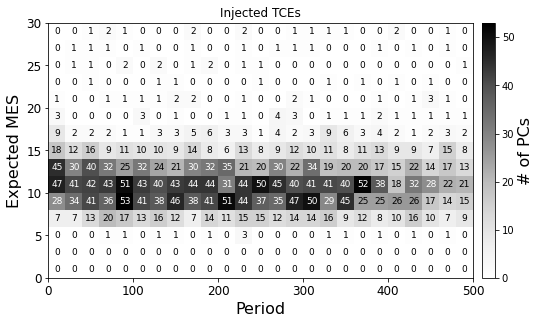

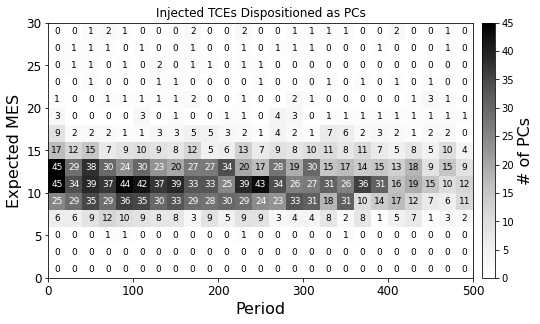

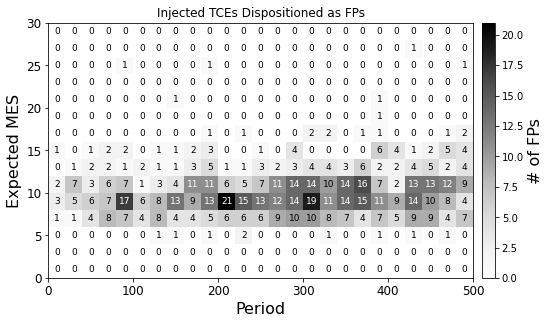

In [19]:
ti = 0
drawHeatMap(tceGrid[:,:,ti], (8,8), cellPeriod[:,:,ti], cellMes[:,:,ti], colorBarLabel="# of PCs");           
plt.title("Injected TCEs");
plt.ylabel('Expected MES', fontsize = 16);
plt.xlabel('Period', fontsize = 16);

drawHeatMap(pcGrid[:,:,ti], (8,8), cellPeriod[:,:,ti], cellMes[:,:,ti], colorBarLabel="# of PCs");           
plt.title("Injected TCEs Dispositioned as PCs");
plt.ylabel('Expected MES', fontsize = 16);
plt.xlabel('Period', fontsize = 16);

drawHeatMap(fpGrid[:,:,ti], (8,8), cellPeriod[:,:,ti], cellMes[:,:,ti], colorBarLabel="# of FPs");           
plt.title("Injected TCEs Dispositioned as FPs");
plt.ylabel('Expected MES', fontsize = 16);
plt.xlabel('Period', fontsize = 16);


Compute the PC fraction in each cell.  This is not used in our analysis, but is a qualitative guide suggesting what functions may be the best fit.

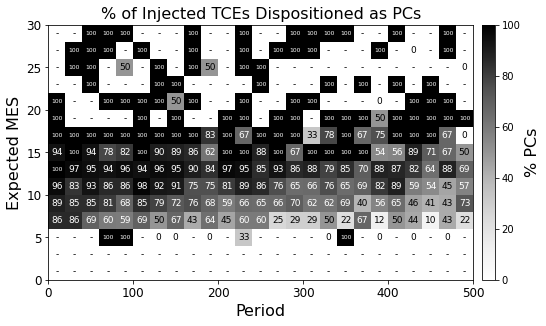

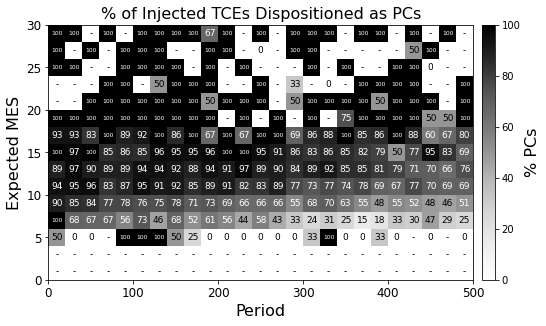

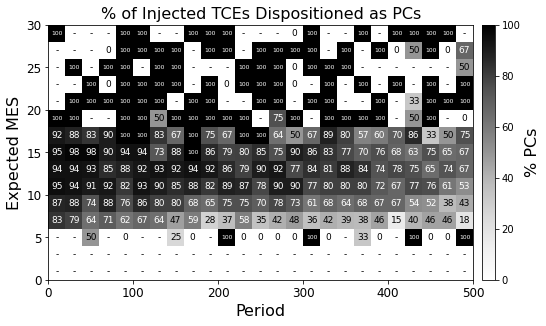

In [20]:
pcFrac = np.zeros(np.shape(tceGrid))
minTcePerCell = 0;
pcFrac[tceGrid>minTcePerCell] = pcGrid[tceGrid>minTcePerCell]/tceGrid[tceGrid>minTcePerCell];

for ti in range(pcFrac.shape[2]):
    drawHeatMap(np.round(100*pcFrac[:,:,ti]), (8,8), cellPeriod[:,:,ti], cellMes[:,:,ti], colorBarLabel="% PCs", nData = tceGrid[:,:,ti]);           
    plt.ylabel('Expected MES', fontsize = 16);
    plt.xlabel('Period', fontsize = 16);
#     plt.savefig(outputDir + "vetCompInjRate.pdf",bbox_inches='tight');
    plt.title("% of Injected TCEs Dispositioned as PCs", fontsize = 16);



From this I conclude there is no measurable dependence of vetting completeness on Teff.  

In [21]:
from astropy.io import fits

# hdulist = fits.open("../completenessContours/out_sc0_GK_baseline_insol_teff_extrap_const.fits.gz")
# hdulist = fits.open("../completenessContours/out_sc0_hab_insol_teff.fits.gz")
hdulist = fits.open("../completenessContours/out_sc0_GK_insol_teff.fits.gz")
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = cumulative_array[2]
prihdr = hdulist[0].header


In [22]:
cumulative_array[3:,:,:].shape

(10, 2000, 2000)

In [23]:
prihdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2000                                                  
NAXIS2  =                 2000                                                  
NAXIS3  =                   13                                                  
EXTEND  =                    T                                                  
MINPER  =                 10.0                                                  
MAXPER  =                500.0                                                  
NPER    =                 2000                                                  
MINRP   =                  0.5                                                  
MAXRP   =                 12.0                                                  
NRP     =                 20

In [24]:
sys.path.insert(0, '..')
import occRateModels as rm
import occRateUtils as ut

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

from scipy import interpolate

nstars = np.zeros(prihdr["NTEFF"])
for i in range(prihdr["NTEFF"]):
    nstars[i] = prihdr["NSTEFF" + str(i)]
print(nstars)
meanTeff = np.zeros(prihdr["NTEFF"])
for i in range(prihdr["NTEFF"]):
    meanTeff[i] = prihdr["MEANT" + str(i)]
print(meanTeff)

innerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 0.75)
outerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 1.77)
print("HZ flux: " + str(innerHZ) + " to " + str(outerHZ))

min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
min_comp_flux = prihdr["MINFLX"]
max_comp_flux = prihdr["MAXFLX"]
# the following matches the insol grid definition in compute_num_completeness_w_ve_insol.py
period_want = np.linspace(max_comp_flux, min_comp_flux, n_comp_period) 
print("grid flux range: " + str(min_comp_flux) + " to " + str(max_comp_flux))
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

cs = ut.compSpace(periodName = "Insolation", 
               periodUnits = "Earth Flux",
               periodRange = (0.2, 2.0), 
               nPeriod = 61, 
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.5, 2.5), 
               nRp = 61)



[  763.  1334.  1675.  2328.  3428.  5115.  7598. 10058. 12416. 12300.]
[4006.96642976 4218.52886863 4436.88694544 4641.22886947 4849.72023073
 5061.81657574 5273.1732001  5483.69706958 5688.41480411 5889.52532242]
HZ flux: 1.7777777777777777 to 0.3191930798940279
grid flux range: 0.1 to 2.1


In [25]:
np.sum(nstars)

57015.0

[4800. 4950. 5100. 5250. 5400. 5550. 5700. 5850. 6000. 6150. 6300.]


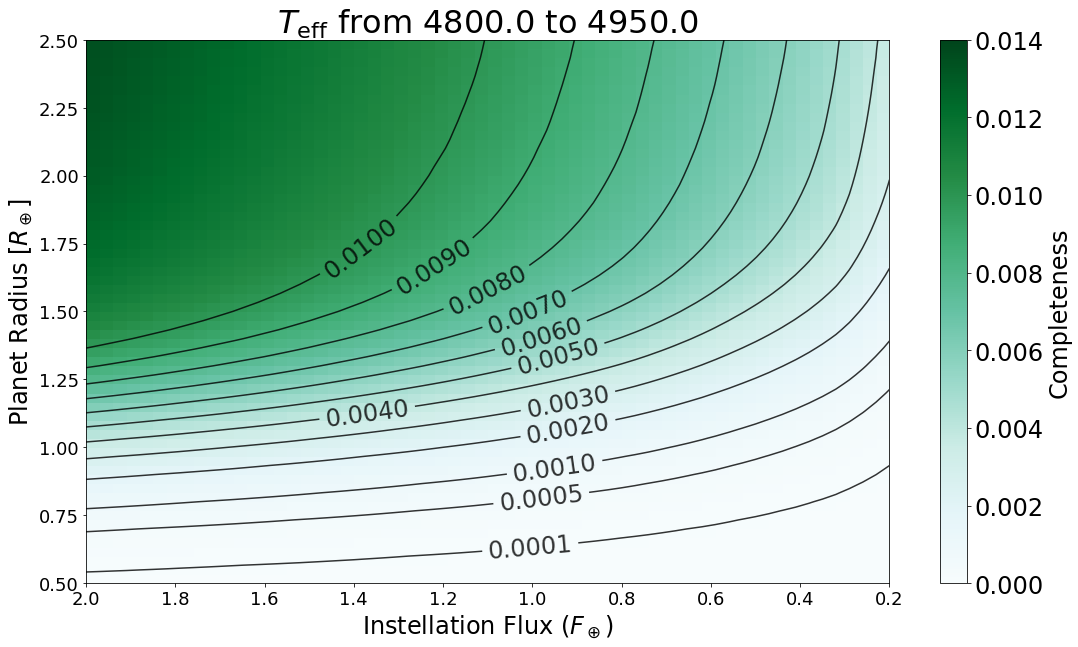

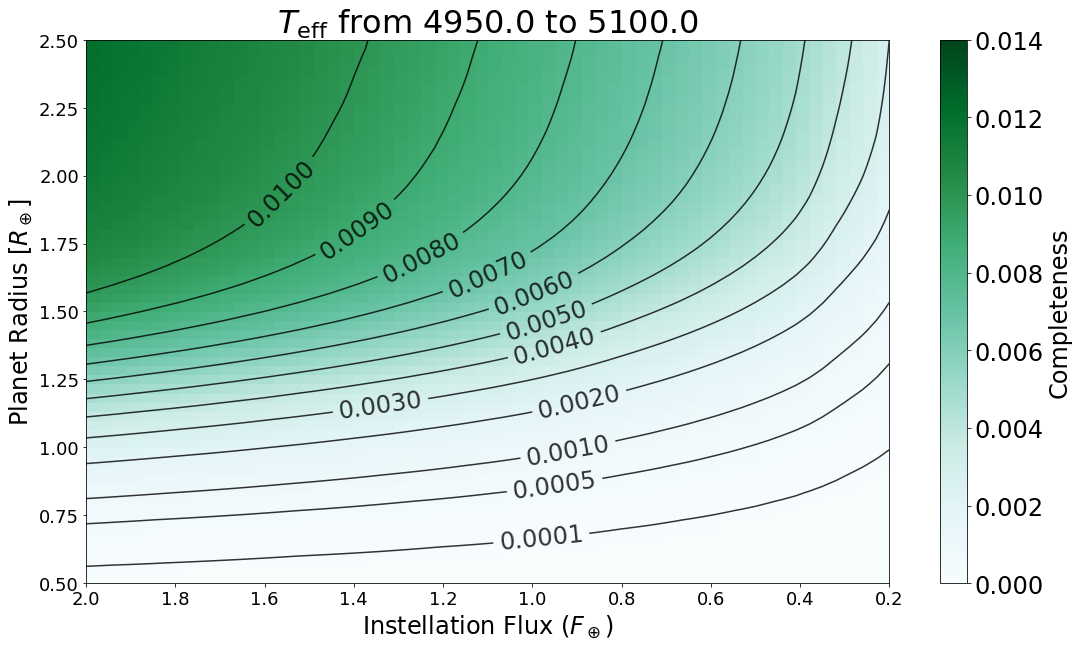

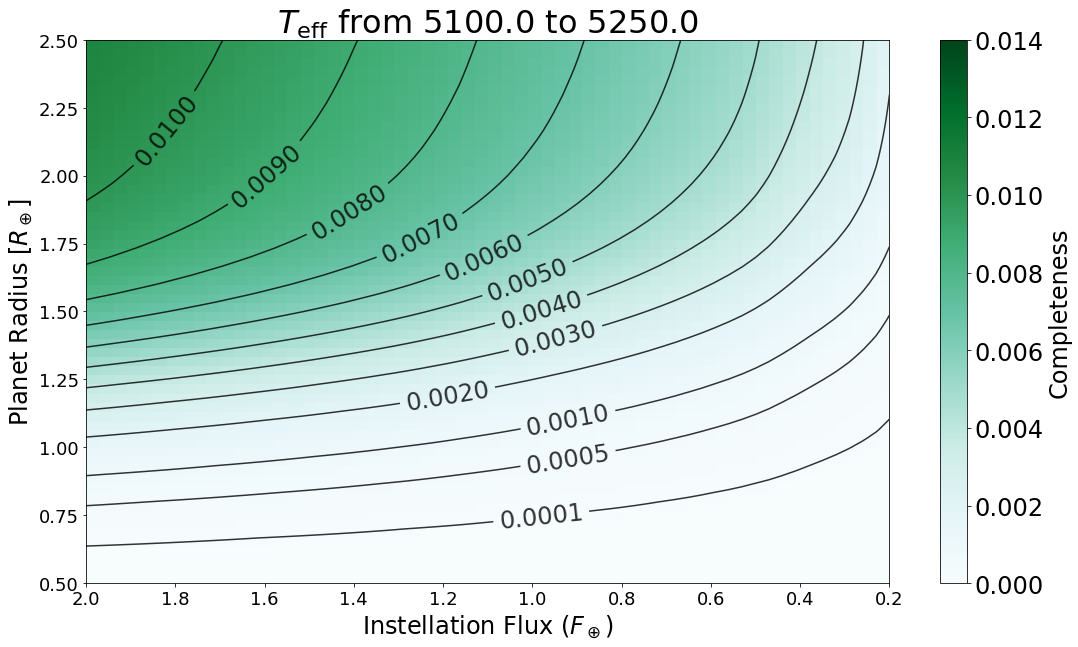

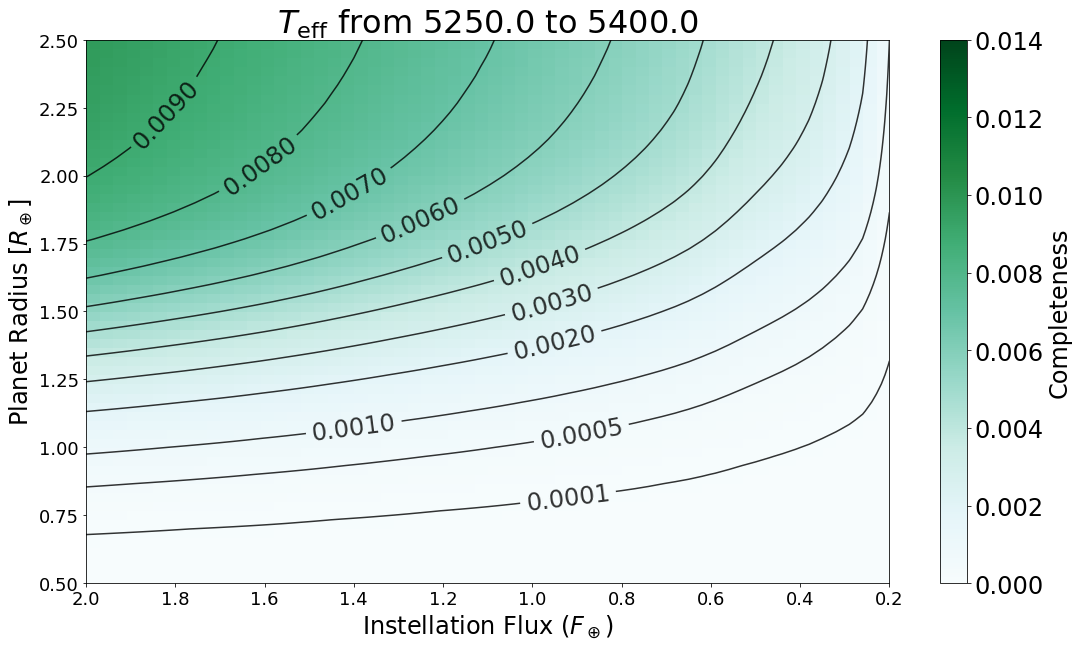

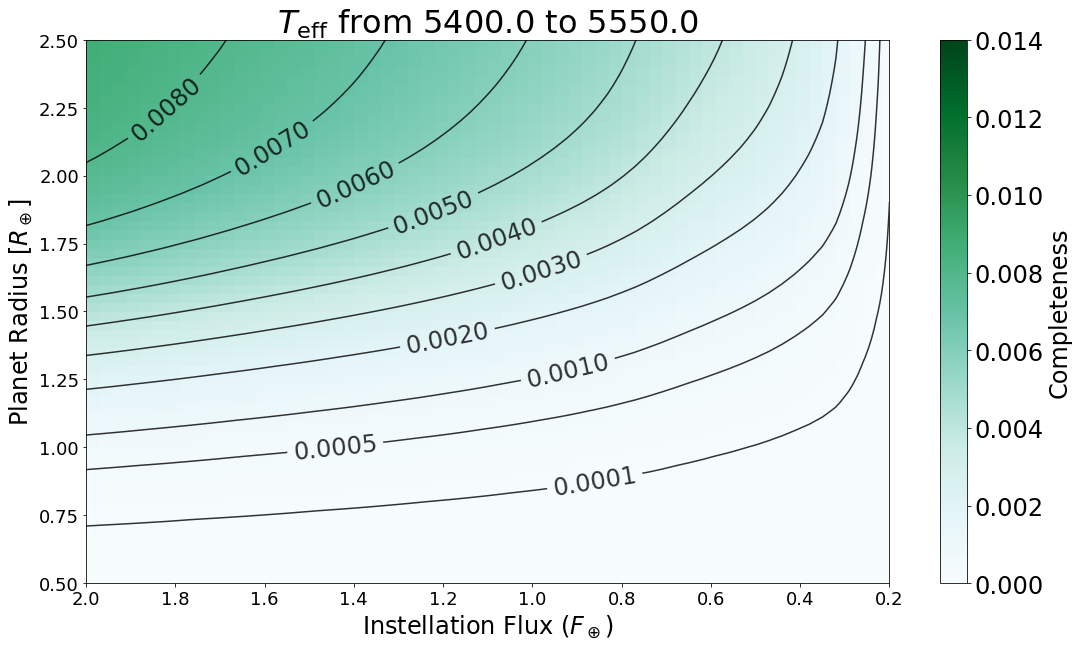

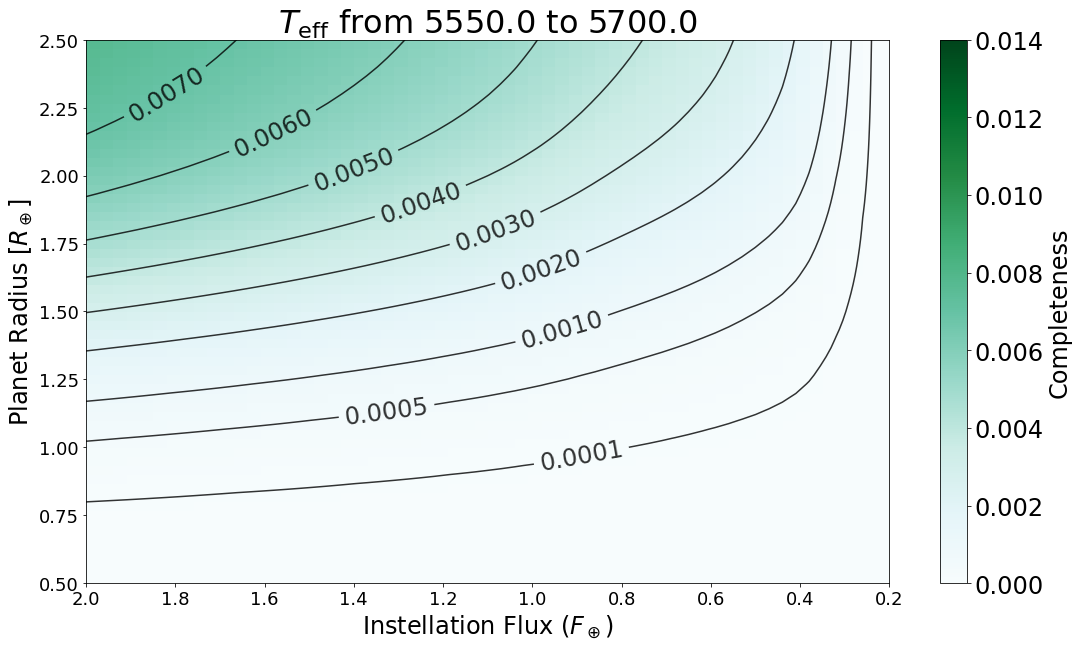

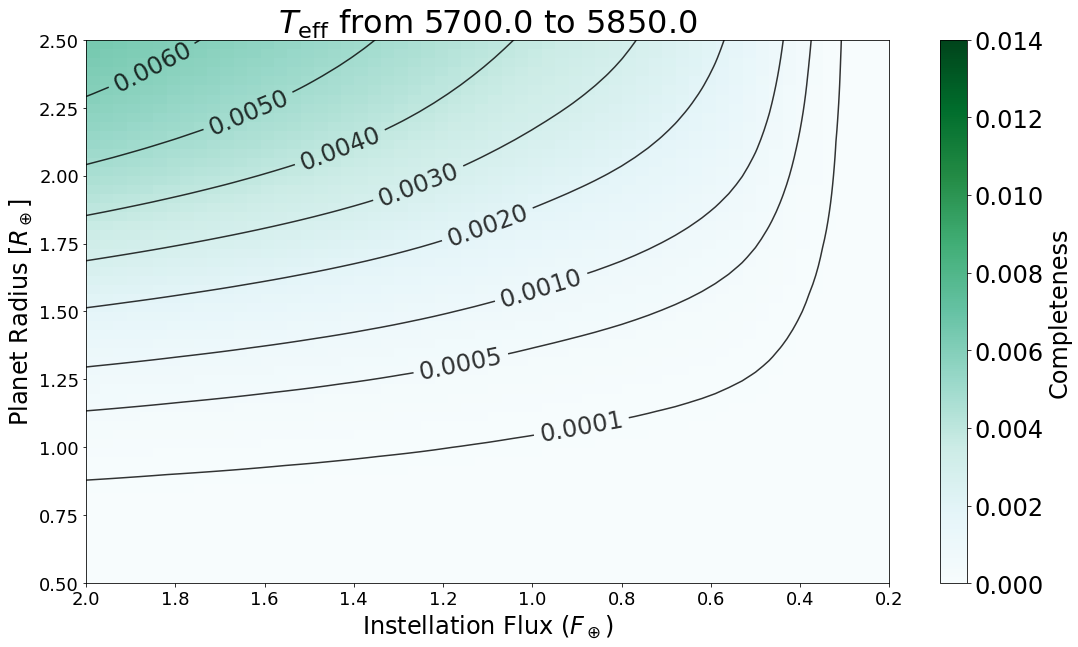

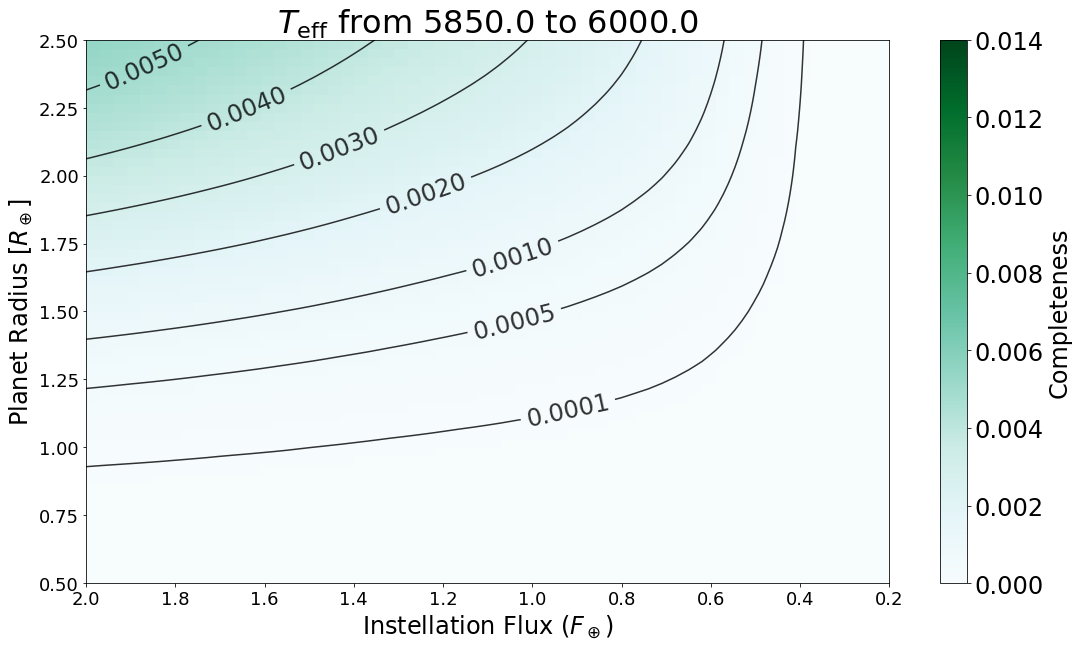

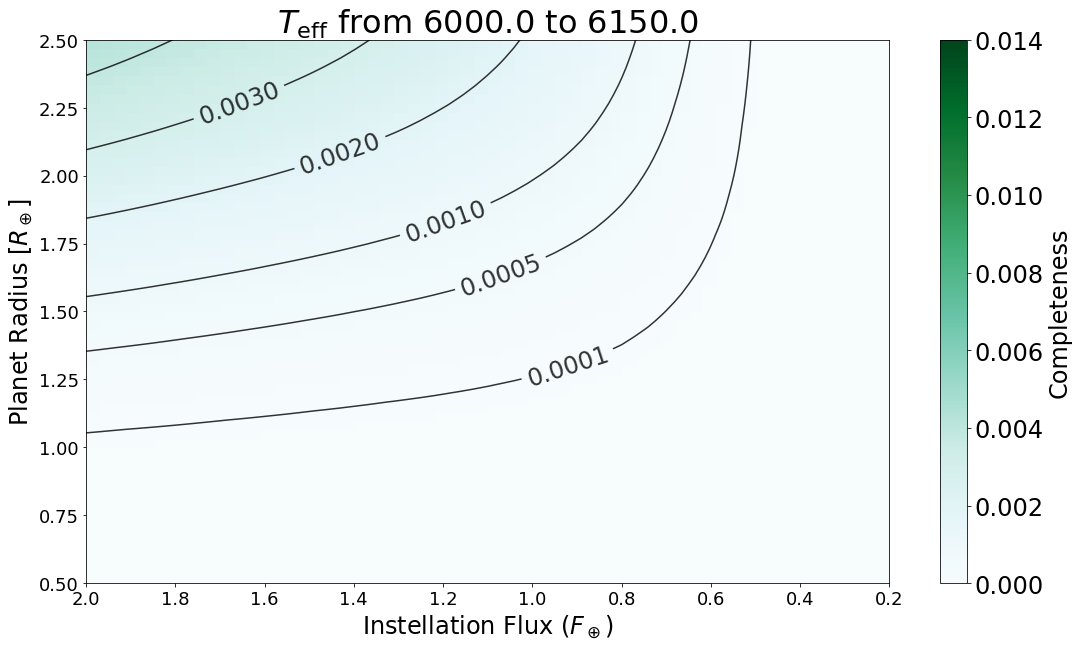

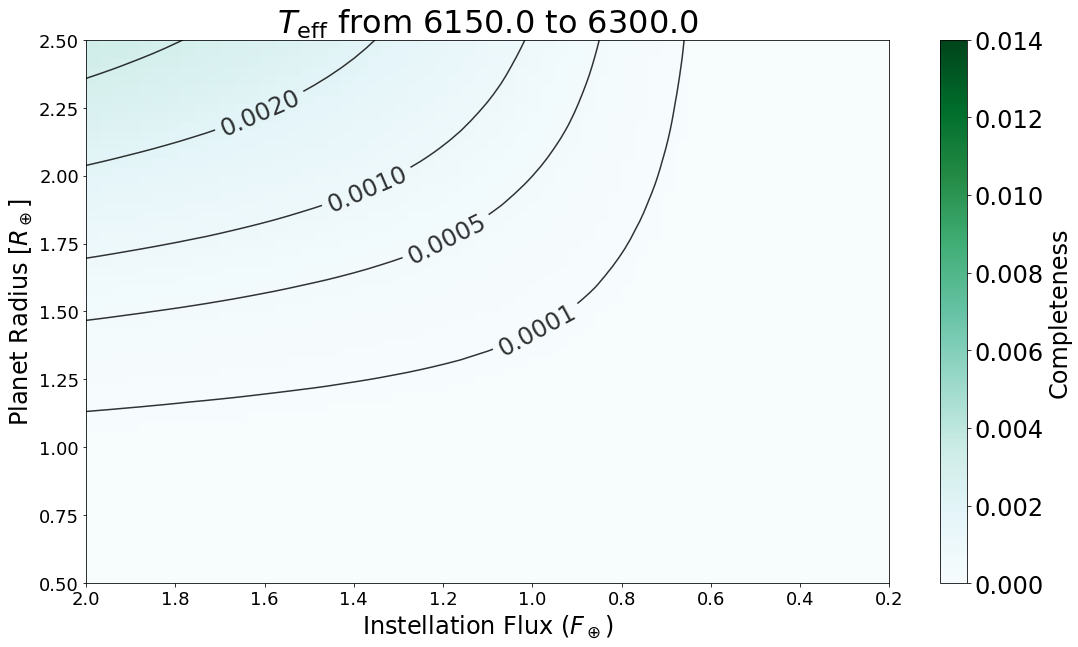

In [32]:
contourLevels = np.arange(1e-2, 1e-1, 1e-2)
contourLevels = np.insert(contourLevels, 0, np.arange(1e-3, 1e-2, 1e-3))
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])
T0 = 4800
TM = 6300
teff = np.linspace(T0, TM, prihdr["NTEFF"]+1)
print(teff)

for teffIdx in range(len(nstars)):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, cumulative_array[3 + teffIdx]);
    summedCompleteness = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))

    fig, ax = plt.subplots(figsize=(18,10));

    pc = plt.pcolor(cs.period2D, cs.rp2D, summedCompleteness / nstars[teffIdx], cmap="BuGn", vmin=0, vmax=0.014)
    c = plt.contour(cs.period2D, cs.rp2D, summedCompleteness / nstars[teffIdx], contourLevels,
                   colors="k", alpha=0.8)

    cbh = plt.colorbar(pc);
    cbh.ax.set_ylabel("Completeness", fontsize = 24);
    cbh.ax.tick_params(labelsize=24)

    #c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
    #               colors="k", alpha=0.8)
    plt.ylim(0.5, 2.5)
    xlim = plt.xlim();
    plt.xlim(xlim[1], xlim[0]);
    # plt.xlim(50, 400)
    plt.clabel(c, fontsize=24, inline=1, fmt="%.4f")
    # plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
    plt.tick_params(labelsize = 18)
    plt.xlabel('Instellation Flux ($F_\oplus$)', fontsize = 24);
    plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 24);
    plt.title("$T_{\mathrm{eff}}$ from " + str(teff[teffIdx]) + " to " + str(teff[teffIdx + 1]), fontsize = 32)
    plt.savefig(figDir + "/teffCompleteness_" + str(teffIdx) + ".pdf",bbox_inches='tight')



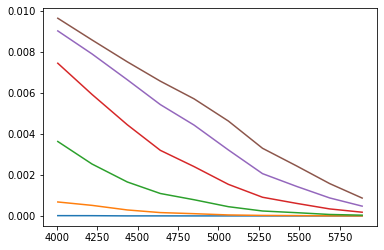

In [27]:
tf = np.zeros((len(nstars), 6))
for teffIdx in range(len(nstars)):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, cumulative_array[3 + teffIdx]);
    summedCompleteness = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))
    for i in range(6):
        tf[teffIdx,i] = summedCompleteness[30,i*10]/nstars[teffIdx]
    
plt.plot(meanTeff,tf);
    

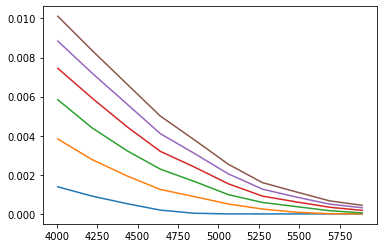

In [28]:
tf = np.zeros((len(nstars), 6))
for teffIdx in range(len(nstars)):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, cumulative_array[3 + teffIdx]);
    summedCompleteness = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))
    for i in range(6):
        tf[teffIdx,i] = summedCompleteness[i*10, 30]/nstars[teffIdx]
    
plt.plot(meanTeff,tf);


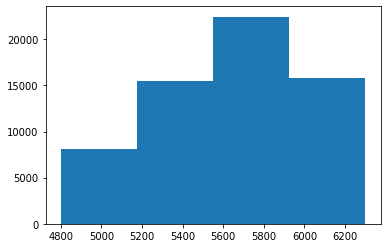

In [29]:
plt.hist(kic['teff'], 4);

In [30]:
nstars

array([  763.,  1334.,  1675.,  2328.,  3428.,  5115.,  7598., 10058.,
       12416., 12300.])